<a href="https://colab.research.google.com/github/SavvinaDaniil/BiasInRecommendation/blob/main/Book%20recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

This notebook should be run on Google Colab.

# Process
In this notebook, I will train the book recommendation algorithms using two different packages: <a href="http://surpriselib.com/">Surprise</a> & <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

## A. Import libraries

In [1]:
!pip install cornac
!pip install surprise

In [2]:
%tensorflow_version 1.x
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
#from run_algorithms import train_algorithms, train_algorithms_kf, prepare_dataset, prepare_dataset_kf
from tqdm import tqdm
import time
pd.set_option("display.precision", 6)
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, NMF
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

TensorFlow 1.x selected.


## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [3]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "book" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)
test_size = 0.2 # the percentage of "hold out" data that are used for testing
rating_threshold = 1.0 # needed for the cornac library
rd.seed(my_seed)
np.random.seed(my_seed)

These additions will be useful so we can load and save the different files (plots and processed data) with clarity on the hyperparameters.

In [4]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

In [5]:
#rd.seed(my_seed) #seed for random functions
#np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [6]:
user_events_file = "https://raw.githubusercontent.com/SavvinaDaniil/BiasInRecommendation/main/data/processed/"+recommendation_type+"/ratings"+addition_1+".csv"
high_user_file = "https://raw.githubusercontent.com/SavvinaDaniil/BiasInRecommendation/main/data/processed/"+recommendation_type+"/high_users"+addition_4+".csv"
low_user_file = "https://raw.githubusercontent.com/SavvinaDaniil/BiasInRecommendation/main/data/processed/"+recommendation_type+"/low_users"+addition_4+".csv"
medium_user_file = "https://raw.githubusercontent.com/SavvinaDaniil/BiasInRecommendation/main/data/processed/"+recommendation_type+"/med_users"+addition_4+".csv"
df_item_dist_file = "https://raw.githubusercontent.com/SavvinaDaniil/BiasInRecommendation/main/data/processed/"+recommendation_type+"/item_pop_dist"+addition_1+".csv"

In [7]:
os.system("wget "+user_events_file)
os.system("wget "+low_user_file)
os.system("wget "+high_user_file)
os.system("wget "+medium_user_file)
os.system("wget "+df_item_dist_file)

0

In [8]:
low = pd.read_csv(low_user_file, index_col=0)
med = pd.read_csv(medium_user_file, index_col=0)
high = pd.read_csv(high_user_file, index_col=0)

In [9]:
num_users = len(low) + len(med) + len(high)
print(num_users)

6358


In [10]:
df_item_dist = pd.read_csv(df_item_dist_file, index_col = 0)

## D. Recommendation 

### Cornac

In [11]:
# load dataset in Cornac
reader = Reader()
data = reader.read(user_events_file.split("/")[-1],sep =",", skip_lines =1)

In [12]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=123)

In [13]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          # 4: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123),
          # 5: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123),
          # 6: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001),
          # 7: NMF
          NMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 8: WMF
          WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 9: PF
          HPF(k=50, seed=123, hierarchical=False, name="PF"),
          # 10: NueMF
          NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 11: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [14]:
# define metrics to evaluate the models
metrics = [MAE(), MSE(), RMSE(), AUC(), MAP(), MRR(), 
           Precision(k=5), Precision(k=10), Precision(k=20), Precision(k=50),
           Recall(k=5), Recall(k=10), Recall(k=20), Recall(k=50),
           NDCG(k=5), NDCG(k=10), NDCG(k=20), NDCG(k=50),
           FMeasure(k=5), FMeasure(k=10), FMeasure(k=20), FMeasure(k=50)]

# put it together in an experiment, voilà!
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Learning...
Learning completed!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


TEST:
...
        |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
------- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
MostPop | 2.5096 |  9.9800 | 2.7869 | 0.6482 | 0.0109 | 0.0105 | 0.0105 | 0.0090 | 0.0153 | 0.0369 |  0.0185 |  0.0237 | 0.0151 |  0.0333 |       0.0080 |       0.0066 |      0.0097 |       0.0050 |    0.0263 |    0.0422 |   0.0161 |    0.0771 |    0.0104 |  33.4535
BPR     | 6.6030 | 46.9219 | 6.6970 | 0.6718 | 0.0109 | 0.0104 | 0.0105 | 0.0089 | 0.0155 | 0.0369 |  0.0185 |  0.0236 | 0.0151 |  0.0331 |       0.0080 |       0.0065 |      0.0095 |     

In [15]:
def compute_user_knn(C):
  ctime = time.time()
  print("Training User-based Collaborative Filtering...", )

  sim = C.dot(C.T)
  norms = [norm(C[i]) for i in range(C.shape[0])]

  for i in tqdm(range(C.shape[0])):
    sim[i][i] = 0.0
    for j in range(i+1, C.shape[0]):
      sim[i][j] /= (norms[i] * norms[j])
      sim[j][i] /= (norms[i] * norms[j])

  print("Done. Elapsed time:", time.time() - ctime, "s")
  rec_score = sim.dot(C)
  return rec_score

In [16]:
def read_training_data():
  training_matrix = np.zeros((rs.train_set.matrix.shape[0], rs.train_set.matrix.shape[1]))
  for uid in tqdm(rs.train_set.uid_map.values()):
    for iid in rs.train_set.iid_map.values():
      training_matrix[uid, iid] = rs.train_set.matrix[uid, iid]
  return training_matrix

In [17]:
# creating users-books rating matrix (will be used for User-KNN algorithm)
training_matrix = read_training_data()

100%|██████████| 6358/6358 [22:32<00:00,  4.70it/s]


In [18]:
# running User-KNN algorithms and getting the user-book scores
user_knn_scores = compute_user_knn(training_matrix)

Training User-based Collaborative Filtering...


100%|██████████| 6358/6358 [00:24<00:00, 261.18it/s] 


Done. Elapsed time: 33.38627624511719 s


In [19]:
# UserKNN recommendation algorithm
def get_top_n_UserKNN(n=10):
    print("User-KNN model is selected:")
    top_n = defaultdict(list)
    # test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      user_id = list(rs.train_set.user_ids)[uid]
      top_n_items_idxs = list(reversed(user_knn_scores[uid].argsort()))[:n]
      for iid in top_n_items_idxs:
        item_id = list(rs.train_set.item_ids)[iid]
        top_n[int(user_id)].append((int(item_id), user_knn_scores[uid][iid]))
    return top_n

In [20]:
def get_top_n(algo_name, n=10):
  for model in exp.models:
    if model.name == algo_name:
      print(model.name + " model is selected:")
      top_n = defaultdict(list)
      for uid in model.train_set.uid_map.values():
        user_id = list(model.train_set.user_ids)[uid]
        try:
          item_rank = model.rank(user_idx=uid)[0]
        except:
          item_rank = model.rank(user_idx=int(uid))[0]
        # collect top N items
        item_rank_top = item_rank[:n]
        for iid in item_rank_top:
          item_id = list(model.train_set.item_ids)[iid]
          top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [21]:
# random recommendation algorithm
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)
    test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(test_items)), i))
    return top_n

In [22]:
df_item_dist.head()

,count
421,0.055049
424,0.043567
1365,0.031299
1464,0.029569
2836,0.028311


In [23]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    elif algo_names[i] == 'UserKNN':
      top_n = get_top_n_UserKNN(n=10)
    else:
      top_n = get_top_n(algo_names[i], n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(df_item_dist["count"].loc[iid_list]) / len(iid_list)
        if uid in low.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in med.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high.index:
            high_rec_gap += gap
            high_count += 1
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

Random model is selected:
MostPop model is selected:
User-KNN model is selected:
MF model is selected:
PMF model is selected:
BPR model is selected:
NMF model is selected:
WMF model is selected:
PF model is selected:
NeuMF model is selected:
VAECF model is selected:


# Test

In [24]:

df_item_dist.head()

,count,Random,MostPop,UserKNN,MF,PMF,BPR,NMF,WMF,PF,NeuMF,VAECF
421,0.055049,11,6358,3612,102,154,6358,0,1087,1198,6358,3335
424,0.043567,7,6358,2102,103,387,6358,0,685,679,6358,2317
1365,0.031299,11,6358,1622,137,404,6358,0,514,605,6358,1766
1464,0.029569,8,6358,1181,128,500,6358,0,413,373,6358,1560
2836,0.028311,8,6358,714,27,81,6358,1,403,606,0,1456


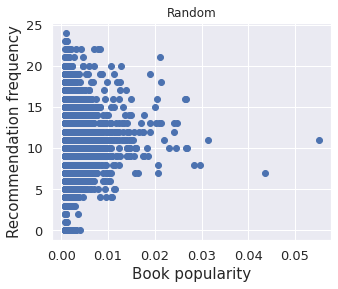

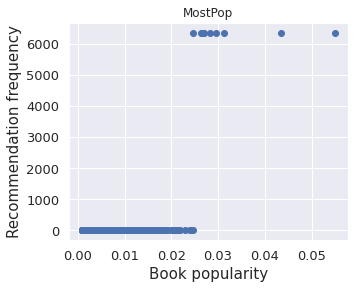

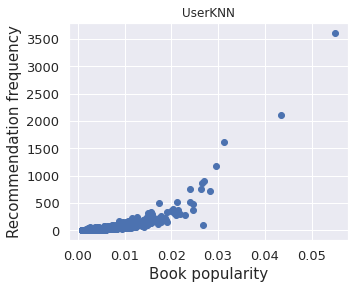

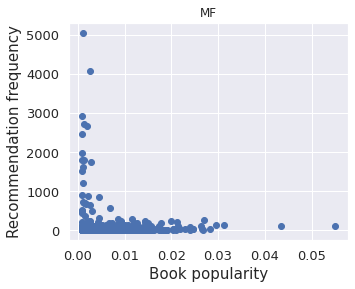

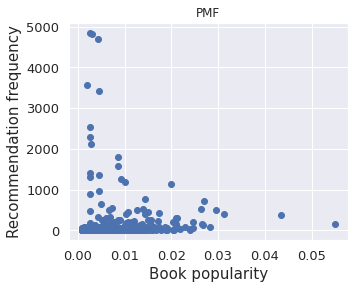

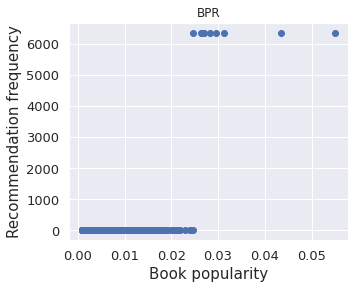

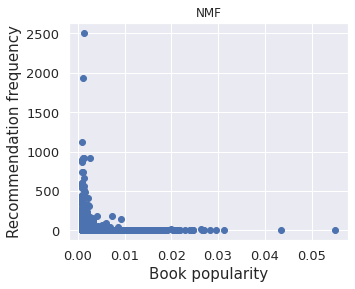

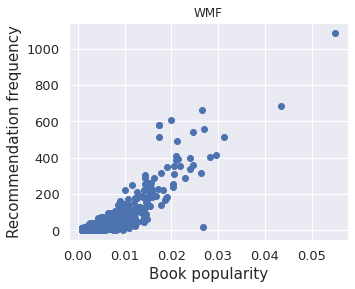

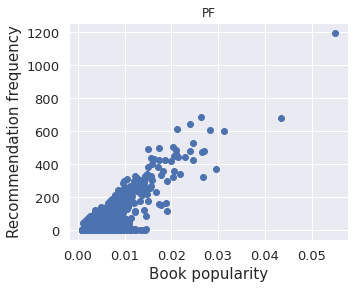

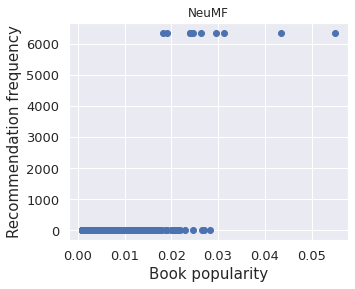

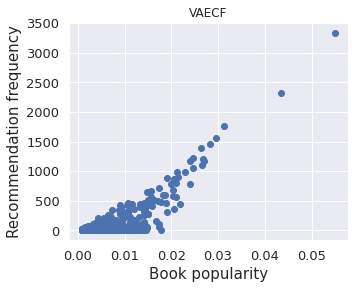

In [25]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist["count"]
    y = df_item_dist[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    #plt.savefig('rec_' + algo_names[i] + '.pdf', dpi=300, bbox_inches='tight')

## Save files
To save:
1. df_item_dist
2. low_rec_gap_list etc
3. exp.result

In [28]:
from google.colab import drive
import pickle as pkl
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
exp.result

In [ ]:
with open(,"wb") as f:
  pkl.dump()

In [ ]:
df_item_dist.to_csv("/content/drive/My Drive/item_pop_dist"+addition_1+"_results.csv")

In [ ]:
cv2.imwrite('/content/drive/My Drive/Delete/res.png' , rgb_img)